In [1]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [86]:
def load_data(filename):
    x = scipy.io.loadmat(filename)['PDmean']
    return x

# def plot_data(x, title, savefig=False, dt=0.0769, color='k'):
#     x_df = pd.DataFrame(x)  #Put data into Pandas dataframe
#     x_df.index = x_df.index*dt  #convert index to time in seconds
#     x_df.plot(subplots=True, layout=(12, 4), figsize=(20, 20), sharey=True, legend=False, color=color);
#     plt.suptitle(title, fontsize=15)
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)
#     if savefig:
#         plt.savefig('figures/'+title+'.pdf',dpi=1000);

def plot_data(data_list, dt=0.0769, fig_size=(20,20), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    n_col = len(speed)
    n_sti = data_list[0].shape[1]
    x_values = np.arange(data_list[0].shape[0]) * dt
    f, ax = plt.subplots(n_sti/n_col, n_col, sharex=True, sharey= True, figsize=fig_size)
    c_count = 0
    for data in data_list:
        count = 0
        for i in range(n_sti/n_col):
            for j in range(n_col):
                ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy

# def Ca_model(x, p, dt=0.0769):
#     x_thres = threshold_cut(x, p['thres'])
#     x_thres_bp1 = bandpass(x_thres, p['tauhp'], p['taulp1'], dt)
#     x_1 = x_thres_bp1 * p['gain1']
#     x_thres_bp2 = bandpass(x_thres, p['tauhp'], p['taulp2'], dt)
#     x_2 = x_thres_bp2 * p['gain2']
#     y = x_1 + x_2
#     return y

def Ca_model(x, p, dt=0.0769):
    """ p is a tuple containing parameters in this order : thres, tauhp, taulp1, gain1, taulp2, gain2"""
    x_thres = threshold_cut(x, p[0])
    x_thres_bp1 = bandpass(x_thres, p[1], p[2], dt)
    x_1 = x_thres_bp1 * p[3]
    x_thres_bp2 = bandpass(x_thres, p[1], p[4], dt)
    x_2 = x_thres_bp2 * p[5]
    y = x_1 + x_2
    #y = np.roll(y, int(p[6]), axis=0)
    return y
    

In [87]:
global T4_Arclight

filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat'
T4_Arclight = load_data(filename)
#plot_data(T4_Arclight, 'T4c_Arclight', savefig=False, color='black')
#T4_Arclight.shape

In [88]:
#param = {'thres':0.0, 'tauhp':0.05, 'taulp1':3.0, 'gain1':100.0, 'taulp2':3.0, 'gain2':60.0, 'shift':0}
param = (0.0, 0.05, 3.0, 100.0, 3.0, 60.0, 0) #thres, tauhp, taulp1, gain1, taulp2, gain2, shift

In [89]:
temp = Ca_model(T4_Arclight, param)
#plot_data(temp, 'temp', savefig=False, color='black')

In [90]:
global T4_Gcamp
filename = 'data/T4c_GCaMP/Ori_Mean_Velocity.mat'
T4_Gcamp = load_data(filename)
#plot_data(T4_Gcamp, 'T4c_Gcamp', savefig=True, color='blue')

In [91]:
T4_Arclight.shape[0]

113

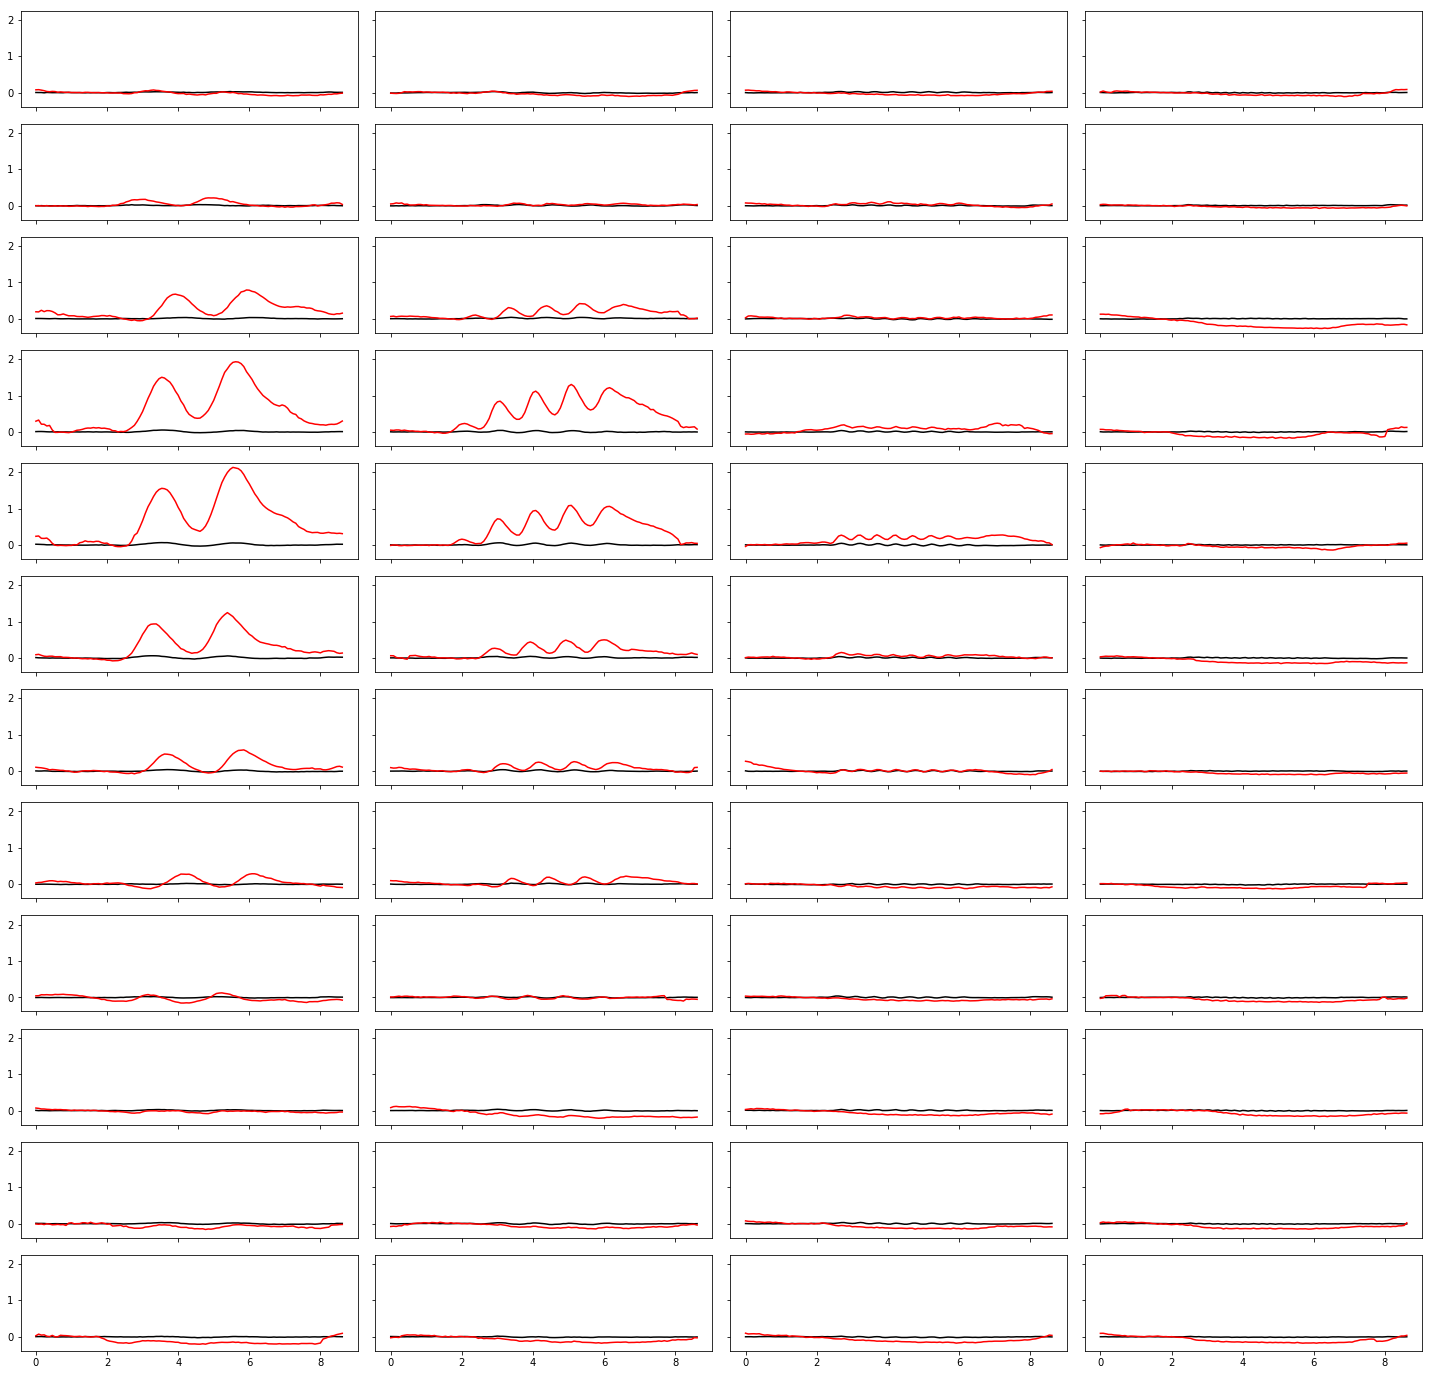

In [92]:
plot_data([T4_Arclight, T4_Gcamp])

In [28]:
data_list = [T4_Arclight, T4_Gcamp]
data = data_list[0]
speed = [15, 30, 60, 120] #velocity in deg/sec
n_col = len(speed)
n_sti = data.shape[1]
# f, ax = plt.subplots(n_sti/n_col, n_col, sharey= True, figsize=(15,15))
# [ax[i].plot(data[:,i]) for i in range(48)];

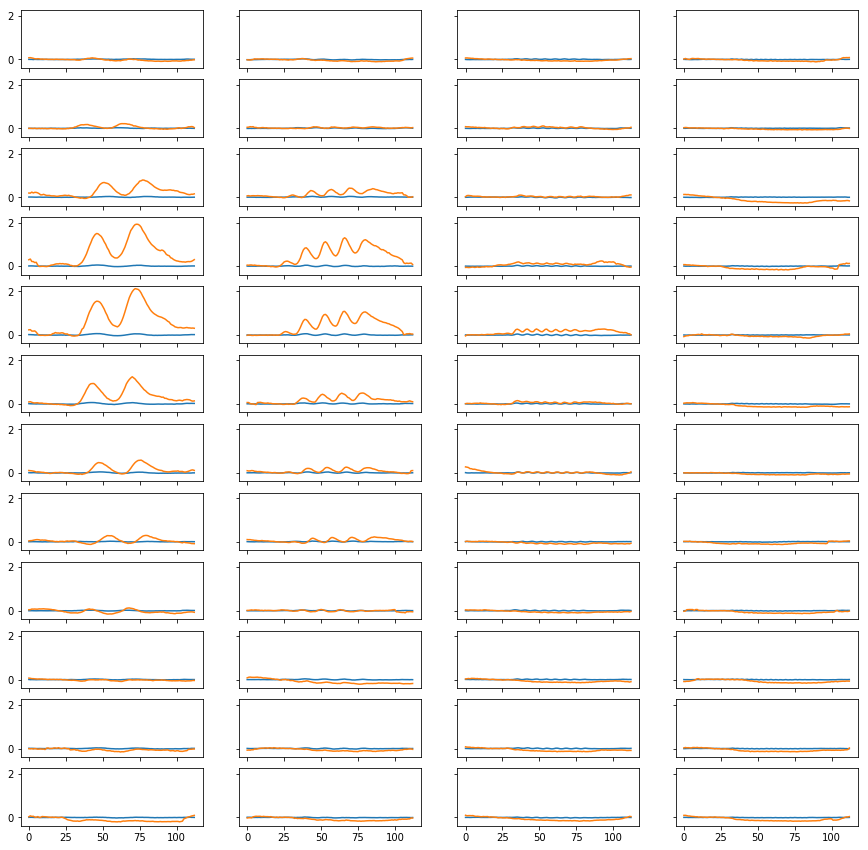

In [42]:
f, ax = plt.subplots(n_sti/n_col, n_col, sharex = True, sharey= True, figsize=(15,15))
for data in data_list:
    count = 0
    for i in range(n_sti/n_col):
        for j in range(n_col):
            ax[i, j].plot(data[:, count])
            count = count + 1

In [15]:
data[:,0].shape

(113,)

In [227]:
def calc_error(p):
    T4Ca_model = Ca_model(T4_Arclight, p)
    #T4Ca_model = np.roll(T4Ca_model, int(p[6]), axis = 0)
    error1 = np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2))
    error2 = np.sqrt(np.mean((T4_Gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2))
    timeerror = 1.0
    error = timeerror*error1 + (1.0-timeerror)*error2
    return error

In [234]:
def fit_params(n):
    #p = np.random.rand(n) #creates n random parameter values
    p = (0.015, 0.05, 3.0, 100.0, 3.0, 60.0, 0)
    #options={'maxiter':5000}     # maximum number of iterations
    p_bounds = ((-10, 10),(-10, 10),(-10, 10),(-10, 300),(-10, 10),(-10, 300),(-10, 10)) #bounds for parameter values
    res = minimize(calc_error, p, tol=1e-10, bounds=p_bounds) #, options=options)
    if res.success:
        print('Optimization successful')
    else:
        print('Optimization not successful') 
    p = res.x
    print(res)
    print(p)
    print('Remaining Error: ', format(calc_error(p),".2f"))
    return p

In [235]:
model_p = fit_params(7)
T4Ca_model = Ca_model(T4_Arclight, model_p)


Optimization successful
      fun: 0.22686430843445918
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -5.55111512e-09,  1.94289029e-08, -2.77555756e-09,
       -1.11022302e-08,  5.75373083e-06,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 672
      nit: 65
   status: 0
  success: True
        x: array([ 1.50000000e-02,  2.69797481e+00,  2.84219137e+00,  6.25491839e+01,
        1.44488467e+00, -1.00000000e+01,  0.00000000e+00])
[ 1.50000000e-02  2.69797481e+00  2.84219137e+00  6.25491839e+01
  1.44488467e+00 -1.00000000e+01  0.00000000e+00]
('Remaining Error: ', '0.23')


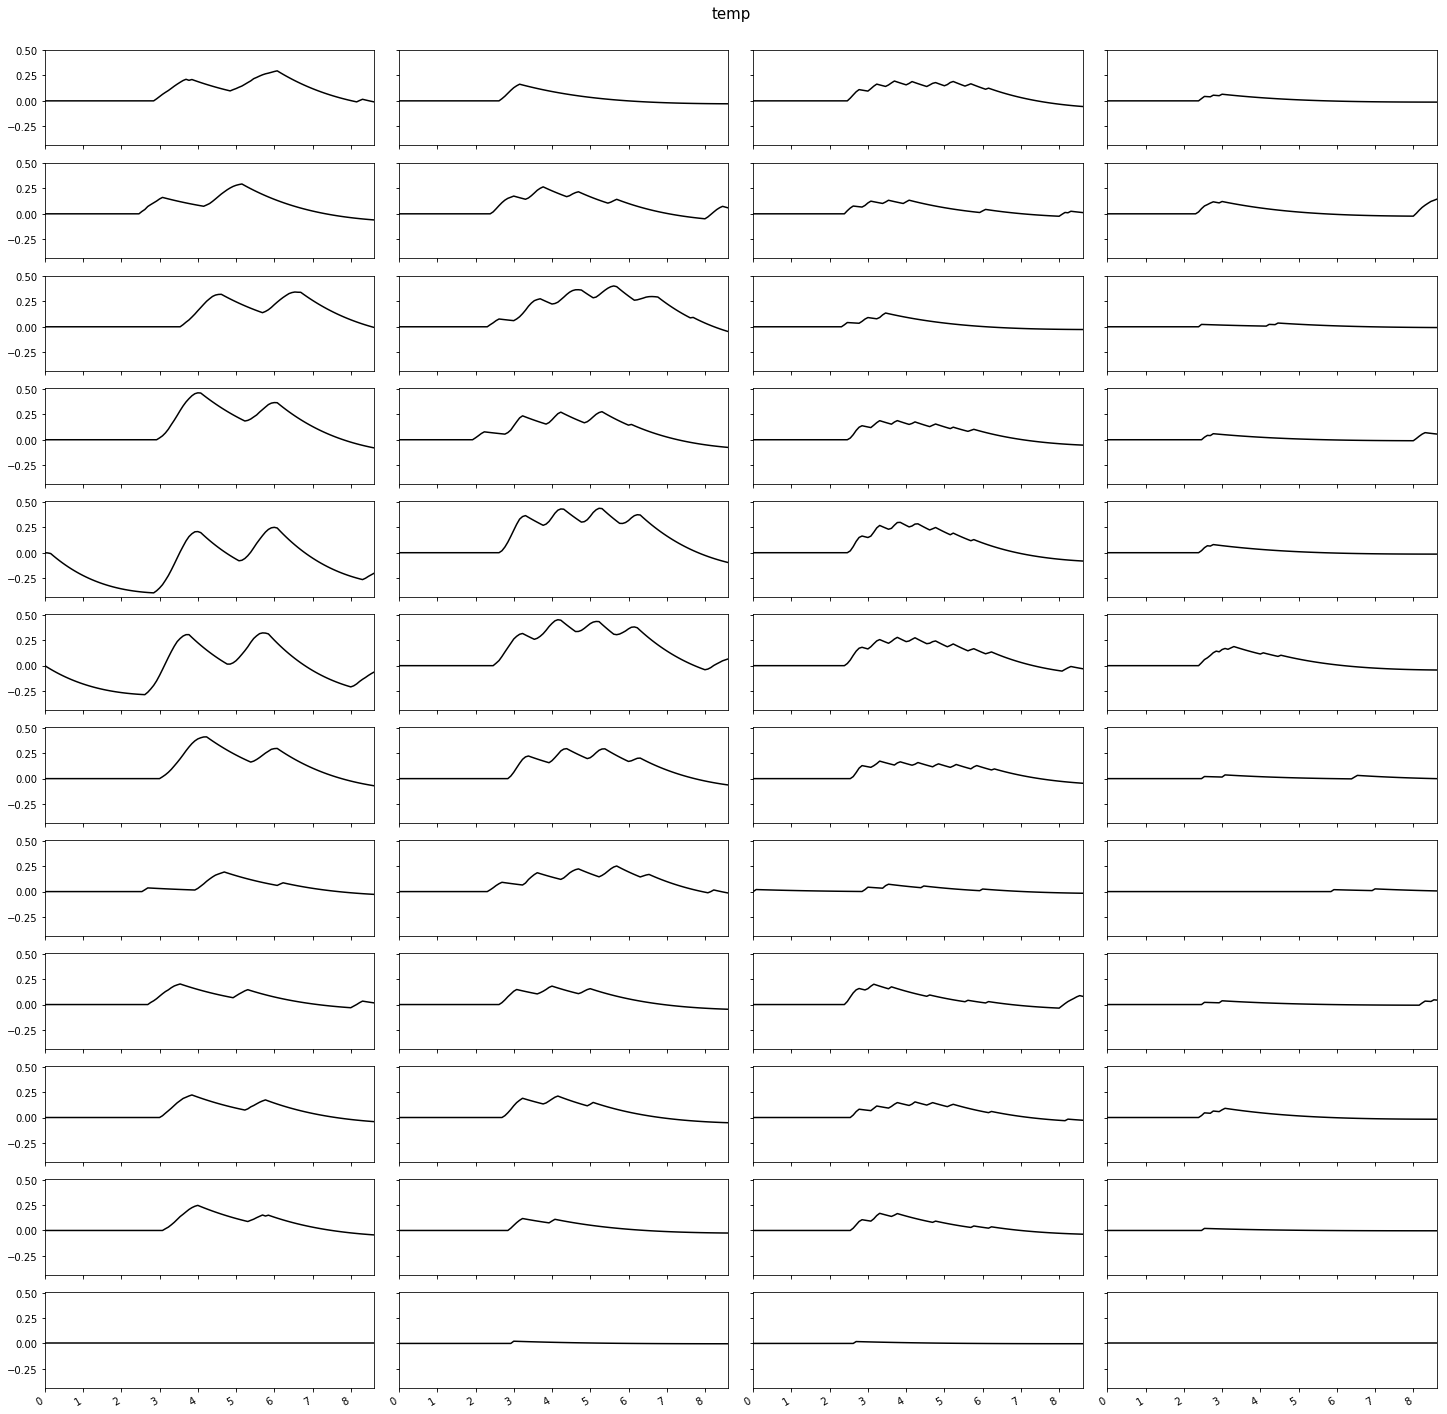

In [236]:
plot_data(T4Ca_model, 'temp', savefig=False, color='black')

In [219]:
res

      fun: 0.3124037187529958
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 0
   status: 0
  success: True
        x: array([0.62896485, 0.59871698, 0.50743542, 0.07119047, 0.80272512,
       0.13447151, 0.67888824])

In [155]:
#options={'maxiter':5000}
p_bounds = ((-10, 10),(-10, 10),(-10, 10),(-10, 300),(-10, 10),(-10, 300),(-10, 10))

In [161]:
#res = minimize(calc_error, (0.0, 0.05, 3.0, 100.0, 3.0, 60.0, 0),tol=1e-10, bounds=p_bounds)#, options=options)
res = minimize(calc_error, np.random.rand(7),tol=1e-10, bounds=p_bounds)#, options=options)
res

      fun: 0.3124037187529958
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 0
   status: 0
  success: True
        x: array([0.62896485, 0.59871698, 0.50743542, 0.07119047, 0.80272512,
       0.13447151, 0.67888824])

In [157]:
if res.success:
    print('Optimization successful')
else:
    print('Optimization not successful')  
p = res.x
print('Remaining Error: ', format(calc_error(p),".2f")) 

Optimization successful
('Remaining Error: ', '0.31')


In [158]:
model_p = res.x
model_p[0]

0.2727046960478707

In [159]:
T4Ca_model = Ca_model(T4_Arclight, model_p)

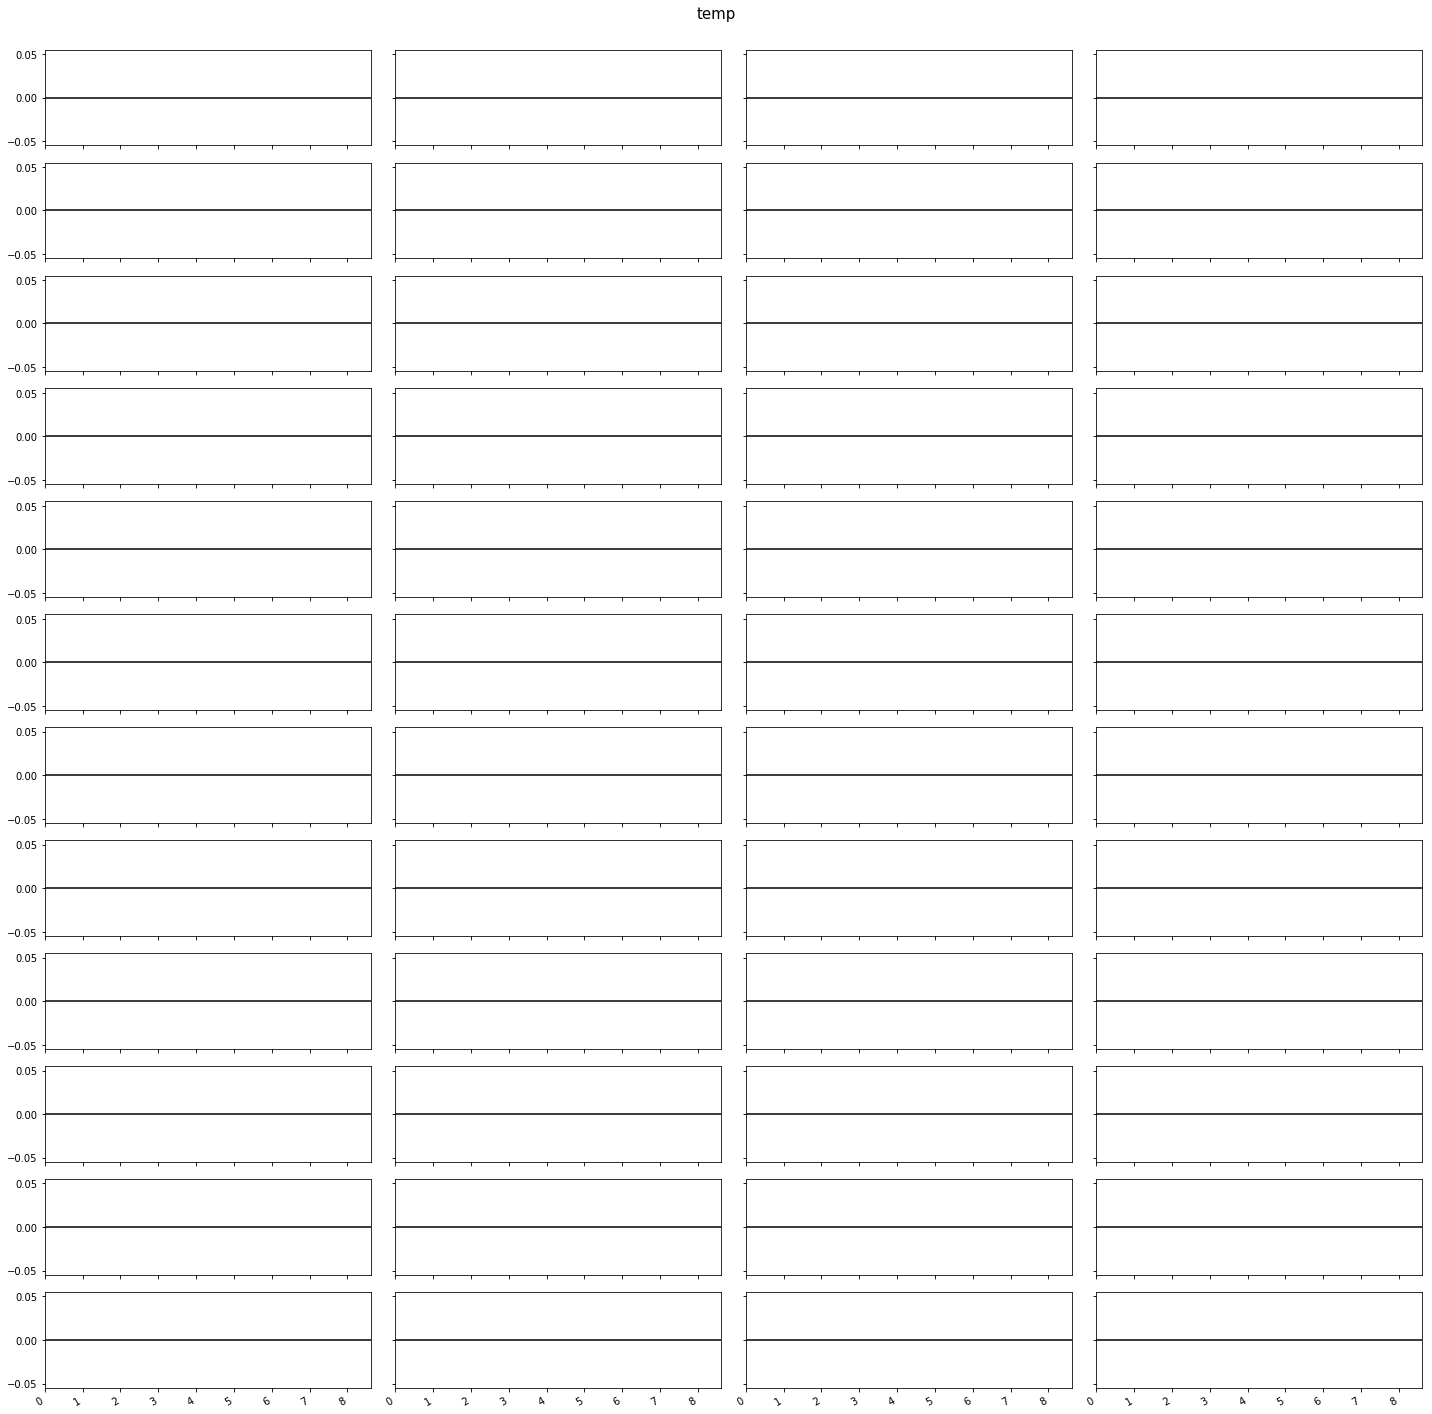

In [160]:
plot_data(T4Ca_model, 'temp', savefig=False, color='black')

In [17]:
res

      fun: 0.23828901631093055
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.28152840e+02,  1.23462733e+03,
         1.60370585e+02, -1.81260887e+02,  1.61289117e+02],
       [ 0.00000000e+00,  1.23462733e+03,  4.79381255e+04,
         1.18170474e+04, -4.10576726e+04,  1.18706427e+04],
       [ 0.00000000e+00,  1.60370585e+02,  1.18170474e+04,
         3.55946969e+03, -1.40324182e+04,  3.57515540e+03],
       [ 0.00000000e+00, -1.81260887e+02, -4.10576726e+04,
        -1.40324182e+04,  5.88682436e+04, -1.40993550e+04],
       [ 0.00000000e+00,  1.61289117e+02,  1.18706427e+04,
         3.57515540e+03, -1.40993550e+04,  3.59292126e+03]])
      jac: array([ 0.00000000e+00, -6.85080886e-06,  6.70552254e-07,  2.13831663e-06,
        1.62050128e-06,  2.14390457e-06])
  message: 'Optimization terminated successfully.'
     nfev: 400
      nit: 48
     njev: 50
   status: 0
  succes

In [18]:
calc_error(model_p)

0.23828901631093055

In [126]:
t = np.random.randint(20, size=(3, 4))
t

array([[ 5, 19, 16, 10],
       [15, 11,  1,  8],
       [11,  3, 12, 14]])

In [24]:
np.roll(t, 1, axis=0)

array([[ 9, 13, 18, 18],
       [ 1,  0,  4,  2],
       [10, 11, 12,  2]])

In [19]:
np.max(T4_Arclight)

0.06727594607112149

In [21]:
T4_Arclight.max(axis=0).shape

(48,)

In [124]:
from scipy.ndimage.interpolation import shift

In [131]:
shift(t, 1)

array([[ 0,  0,  0,  0],
       [ 0,  5, 19, 16],
       [ 0, 15, 11,  1]])

In [132]:
t

array([[ 5, 19, 16, 10],
       [15, 11,  1,  8],
       [11,  3, 12, 14]])

In [135]:
np.random.rand(6)

array([0.1896086 , 0.01987779, 0.21536355, 0.66675477, 0.847332  ,
       0.26559518])

In [93]:
global p_bounds #bounds on parameters (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift)
p_bounds = ((-1,1),(0,10),(0,10),(0,200),(0,10),(0,200),(-113,113))

In [99]:
np.random.randint(p_bounds[0][0],p_bounds[0][1])

-1

In [97]:
p_bounds[0][0]

-1

In [110]:
[np.random.uniform(bounds[0], bounds[1]) for bounds in p_bounds]

[-0.6815392919308099,
 0.7315287296285256,
 2.345220721676805,
 83.92278504049833,
 0.39817103594138037,
 164.60664464457574,
 8.014546551188246]

In [107]:
np.random.uniform(-1,1,(10,10))

array([[ 0.13739548, -0.62644072, -0.65729184,  0.23520762, -0.7216711 ,
        -0.83389122,  0.55204049,  0.92248823,  0.12391849, -0.60995801],
       [ 0.87206273, -0.83565201,  0.70688067, -0.36618032,  0.95865997,
        -0.74032211, -0.40256208, -0.78955667,  0.23264294, -0.93431143],
       [-0.17511013, -0.18220367,  0.714361  ,  0.98743172,  0.77732608,
         0.08639279, -0.42646296, -0.37353333,  0.87692609,  0.12345861],
       [-0.03233098,  0.5050645 ,  0.0307263 ,  0.09876828,  0.99031244,
        -0.672704  , -0.1416528 , -0.67743757, -0.89593044,  0.95495876],
       [-0.82141313, -0.64073846, -0.81469636,  0.16172273, -0.99032876,
        -0.71133051,  0.39659592,  0.44964374,  0.35258836,  0.68583535],
       [-0.21430306,  0.16613007,  0.2366269 , -0.73553962, -0.71605236,
        -0.06267244,  0.73688636,  0.56077138,  0.54028642, -0.9114728 ],
       [ 0.22366556,  0.88419895, -0.56564312, -0.4084138 ,  0.66370852,
         0.11995494, -0.16593559, -0.70217838